# Оптимизация технологического процесса в промышленности

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.


**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Цель проекта**

Построить модель, которая будет предсказывать конечную температуру сплава.  Необходимо достичь показателя качества модели машинного обучения MAE не ниже 6,8. 

Прогнозные данные модели необходимы предприятию для уменьшения потребления электроэнергии. Заказчик будет использовать разработанную модель для имитации технологического процесса.

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

*Файл data_arc_new.csv *

- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

*Файл data_bulk_new.csv*

- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

*Файл data_bulk_time_new.csv*

- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

*Файл data_gas_new.csv*

- key — номер партии;
- Газ 1 — объём подаваемого газа.

*Файл data_temp_new.csv*

- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

*Файл data_wire_new.csv*

- key — номер партии;
- Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

*Файл data_wire_time_new.csv*

- key — номер партии;
- Wire 1 … Wire 15 — время подачи проволочных материалов.


Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

##  Загрузка данных

Загрузка необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV, 
                                     RandomizedSearchCV)
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor

from IPython.display import Image
#warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = np.random.seed(190224)

Загрузка файлов.

In [3]:
def read_data(data):
    '''
    Функция загрузки файлов
    Принимает на вход название файла
    Загружает датафрейм
    '''
    pth1 = '/datasets/' + data
    pth2 = 'https://code.s3.yandex.net'+ pth1
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong', data)
    return query_1

In [4]:
data_arc = read_data('data_arc_new.csv')
data_bulk = read_data('data_bulk_new.csv')
data_bulk_time = read_data('data_bulk_time_new.csv')
data_gas = read_data('data_gas_new.csv')
data_temp = read_data('data_temp_new.csv')
data_wire = read_data('data_wire_new.csv')
data_wire_time = read_data('data_wire_time_new.csv')

## Исследовательский анализ и предобработка данных

Откроем каждый файл и ознакомимся с данными в нем.

In [5]:
def get_data_info(data1):
    '''
    Информативная функция о данных датафрейма
    '''
    display(data1.head())
    display(data1.info())
    display(data1.isna().sum())
    display('Кол-во партий:', data1['key'].nunique())
    display(data1.describe(include='all'))
    # Добавить графики по каждому файлу

### data_arcm

In [6]:
get_data_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

'Кол-во партий:'

3214

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-08-04 00:26:30,2019-05-24 14:02:05,NaN,NaN
freq,NaN,1,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175
50%,1617.000000,NaN,NaN,0.599587,0.441639
75%,2429.000000,NaN,NaN,0.830070,0.608201


В файле отмечены данные по 3214 процессам, в 14876 строках за 2,5 месяца наблюдений. Необходимо переименовать столбцы, сменить тип данных в столбцах с данными  о времени нагрева (начало/конец). В столбце "Реактивная мощность" есть отрицательные значения, что противоречит определению мощности. Удалим отрицательные значения. Агрегируем мощности в разрезе каждой партии.

In [7]:
#переименование столбцов
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'start_arc_heating',
                                    'Конец нагрева дугой':'end_arc_heating',
                                    'Активная мощность':'apparent_power',
                                    'Реактивная мощность':'reactive_power'
                                   })

In [8]:
data_arc['start_arc_heating'] = pd.to_datetime(data_arc['start_arc_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc['end_arc_heating'] = pd.to_datetime(data_arc['end_arc_heating'], format='%Y-%m-%d %H:%M:%S')
display(data_arc.head())
data_arc.dtypes

,key,start_arc_heating,end_arc_heating,apparent_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


key                           int64
start_arc_heating    datetime64[ns]
end_arc_heating      datetime64[ns]
apparent_power              float64
reactive_power              float64
dtype: object

In [9]:
#удаление данных с отрицательными значениями

data_arc = data_arc.query('reactive_power > 0')

Определим полную мощность.
Обратимся к теории.

**Полная мощность (S - full_power)**

Полная мощность – это произведение напряжения и тока при игнорировании фазового угла между ними. Вся мощность в сети переменного тока (рассеиваемая и поглощаемая/возвращаемая) является полной.

Комбинация реактивной и активной мощностей называется полной мощностью. Произведение действующего значения напряжения на действующее значение тока в цепи переменного тока называется полной мощностью.

Полная мощность = √ (Активная мощность2 + Реактивная мощность2)

Тригонометрическое соотношение мощностей:


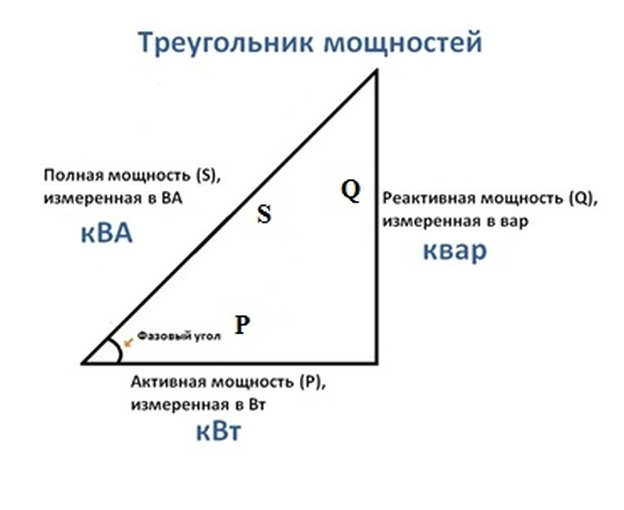

In [10]:
print('Тригонометрическое соотношение мощностей:')
display(Image("https://khomovelectro.ru/images/32/clip_image001.jpg", width=360, height=320))

Расчитаем полную мощность для каждого замера и время нагрева дугой. Выделим данные по каждой партии.

In [11]:
# определение полной мощности
data_arc['full_power'] = (data_arc['apparent_power']**2 + data_arc['reactive_power']**2)**0.5

#выделим кол-во этапов нагревания
rounds_heating = data_arc['key'].value_counts().reset_index(name='rounds_heating').rename(columns={'index': 'key'}).sort_values(by='key', ascending=True)

# определение временого интервала нагрева в секундах
data_arc['time_arc_heating'] = data_arc['end_arc_heating'] - data_arc['start_arc_heating']
data_arc['time_arc_heating'] = data_arc['time_arc_heating'].astype('timedelta64[s]')

In [12]:
display(data_arc.head())
data_arc.dtypes
rounds_heating

,key,start_arc_heating,end_arc_heating,apparent_power,reactive_power,full_power,time_arc_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0


,key,rounds_heating
1140,1,5
2019,2,4
1527,3,5
2231,4,4
2424,5,4
...,...,...
870,3237,5
2563,3238,3
104,3239,8
1491,3240,5


In [13]:
# Составим сводную таблицу относительно полной мощности, времени и кол-ва нагрева по партиям
# Остальны данные не понадобятся в построении модели,т.к.будут коррелирующими признаками
data_arc_final = data_arc.pivot_table(index='key', values=['full_power', 'time_arc_heating'], aggfunc='sum').reset_index()
data_arc_final = data_arc_final.merge(right=rounds_heating, on='key')

Мощность равна отношению работы ко времени, за которое она была совершена. Вычислим работу. 

In [14]:
data_arc_final['work'] = data_arc_final['full_power']*data_arc_final['time_arc_heating']

In [15]:
data_arc_final.head()

,key,full_power,time_arc_heating,rounds_heating,work
0,1,3.718736,1098.0,5,4083.171936
1,2,2.588349,811.0,4,2099.150800
2,3,5.019223,655.0,5,3287.591368
3,4,3.400038,741.0,4,2519.428170
4,5,2.816980,869.0,4,2447.955323


### data_bulk

In [16]:
get_data_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Кол-во партий:'

3129

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В данных много пропусков. Пропуск означает то, что материал данного наименования не добавлялся в  партию . Значит правомерно заполнить их нулями.


In [17]:
data_bulk = data_bulk.fillna(0)

Приведем названия столбцов к стандартному виду

In [18]:
data_bulk.columns = data_bulk.columns.str.replace('Bulk ', 'bulk_', regex=False)

Так же в данных наблюдается малая заполненность по признакам. Можно предположить, что признаки с заполненностью менее 80% могут привести к переобучению модели и сложностям в подборе гиперпараметров.
Таких признаков в этом датафреме достаточно много. Для построения модели возьмем признаки с кол-ом пропусков менее 1800, это:
 bulk_3, bulk_4, bulk_12, bulk_14, bulk_15.

In [19]:
data_bulk_final = data_bulk[['key','bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15']]

In [20]:
data_bulk_final.head()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0


### data_bulk_time

In [21]:
get_data_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Кол-во партий:'

3129

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-05-16 12:14:14,2019-05-07 19:13:07,2019-06-27 12:34:47,2019-07-06 16:18:32,2019-09-01 09:37:36,2019-08-06 07:07:25,2019-07-27 19:15:43,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-07-31 11:10:59,2019-07-24 23:08:34,2019-06-19 06:22:29,2019-08-22 14:48:22,2019-07-06 16:18:32,2019-05-15 16:18:32
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация в датасете это время подачи сплавов из бункера для сыпучих материалов. Из данных можно почерпнуть последовательность подачи материалов в сплав. Пока оставим эту информацию, учтем ее при корректировке качества модели.

### data_gas

In [22]:
get_data_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      0
Газ 1    0
dtype: int64

'Кол-во партий:'

3239

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


В датафрейме хранятся полные данные, без пропусков и явных аномалий.

In [23]:
data_gas_final = data_gas.rename(columns={'Газ 1': 'gas'})

In [24]:
data_gas_final.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### data_temp

In [25]:
get_data_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

key                0
Время замера       0
Температура     3427
dtype: int64

'Кол-во партий:'

3216

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
unique,NaN,18092,NaN
top,NaN,2019-06-08 05:03:45,NaN
freq,NaN,1,NaN
mean,1616.460977,NaN,1590.722741
std,934.641385,NaN,20.394381
min,1.000000,NaN,1191.000000
25%,807.750000,NaN,1580.000000
50%,1618.000000,NaN,1590.000000
75%,2429.000000,NaN,1599.000000


Представлены данные замеров температуры по 3216 циклам обработки металла.
Необходимо переименовать столбцы и сгруппировать данные по ключам, высчитав количество итераций по каждому ключу и среднюю температуру. 
В полученном датасете удалим все пропуски(3427) и ключи без двух зафиксированных температур. И температуры ниже 1500 градусов, т.к.это минимальная температура плавления.

In [26]:
#переименование столбцов
data_temp = data_temp.rename(columns={'Время замера':'sample time',
                                     'Температура':'temperature'
                                     })

data_temp['sample time'] = pd.to_datetime(data_temp['sample time'], format='%Y-%m-%d %H:%M:%S')

Обработка пропусков

In [27]:
data_temp = data_temp.dropna().reset_index(drop=True)

In [28]:
#выделим кол-во этапов нагревания
rounds_temp = data_temp['key'].value_counts().reset_index(name='rounds_temp').rename(columns={'index': 'key'}).sort_values(by='key', ascending=True)
rounds_temp

,key,rounds_temp
978,1,6
1891,2,5
853,3,6
1270,4,5
1500,5,5
...,...,...
2722,3237,1
2594,3238,1
2709,3239,1
3050,3240,1


Данные количества замеров на единицу больше данных количества итераций из файла data_arcm, что обьясняется технологическим процессом. Не будем использовать данные rounds_temp при построении модели, дабы избежать корреляции признаков.

Проверим значение температур(не ниже 1500) и количества замеров (не менее двух).

In [29]:
anomalies = data_temp.query('temperature <= 1500')
display(anomalies)

,key,sample time,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
13987,2561,2019-08-12 18:49:29,1204.0


In [30]:
anomalies2 = rounds_temp.query('rounds_temp < 2')

display(anomalies2.nunique(),anomalies2['key'].unique() )

key            741
rounds_temp      1
dtype: int64

array([ 195,  279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508,
       2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519,
       2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530,
       2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541,
       2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552,
       2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563,
       2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574,
       2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585,
       2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596,
       2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607,
       2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618,
       2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629,
       2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640,
       2641, 2642, 2643, 2644, 2645, 2646, 2647, 26

Пять партии попали в аномальные из-за температуры и 741 из-за отсутствия второго и последущих замеров температуры(195, 279 и все партии с ключем после 2500). Избавимся от них.

In [31]:
data_temp_final = data_temp.query('temperature > 1500 and key != 195 and key != 279 and key < 2500')
data_temp_final.head()

,key,sample time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Дополним датафрейм данными о времени между крайними замерами температуры.

In [32]:
# с помощью сортировки добавим столбцы с крайними замерами 
data_temp_final = data_temp_final.groupby(by = 'key').agg(['first', 'last']).reset_index()

# переименуем столбцы
data_temp_final.columns = ['key', 'first_time', 'finish_time', 'first_temp', 'finish_temp']

#добавим новый признак -  время нагрева
data_temp_final['diff_time_temp'] = data_temp_final['finish_time'] - data_temp_final['first_time']
data_temp_final['diff_time_temp'] = data_temp_final['diff_time_temp'].dt.seconds
data_temp_final['diff_time_temp'] = data_temp_final['diff_time_temp'].astype('float')

# удалим стобцы с исходными данными времени,т.к. новый признак заменяет их
data_temp_final = data_temp_final.drop(['first_time', 'finish_time'], axis=1)

In [33]:
data_temp_final.head()


,key,first_temp,finish_temp,diff_time_temp
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0


### data_wire

In [34]:
get_data_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Кол-во партий:'

3081

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


В датасете представленны данные об обьеме девяти различных проволочных материалов, используемых в тех.процессе. Явные аномалии и отрицательные значения отсутствуют. Большое количество отсутствующих данных говорит о нулевом значении обьема. Исправим это и название столбцов. В данных по многим наименованиям заполненность данных составляет менее 80%. Используем для построения модели лишь данные из Wire 1 и Wire 2. 

In [35]:
data_wire = data_wire.fillna(0).astype('float')

data_wire.columns = data_wire.columns.str.replace('Wire ', 'wire_', regex=False)

In [36]:
data_wire_final = data_wire[['key','wire_1','wire_2']]

In [37]:
data_wire_final.head()

,key,wire_1,wire_2
0,1.0,60.059998,0.00000
1,2.0,96.052315,0.00000
2,3.0,91.160157,0.00000
3,4.0,89.063515,0.00000
4,5.0,89.238236,9.11456


### data_wire_time

In [38]:
get_data_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Кол-во партий:'

3081

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3055,1079,63,14,1,73,11,19,29
top,NaN,2019-07-24 23:17:09,2019-06-10 01:20:50,2019-06-14 22:16:16,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-07-27 19:15:43,2019-08-13 10:25:22,2019-05-14 15:07:59,2019-06-09 22:50:56
freq,NaN,1,1,1,1,1,1,1,1,1
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация в датасете это время подачи проволоки того или иного вида. Из данных можно почерпнуть время подачи проволок в сплав относительно начала процесса. Пока оставим эту информацию, учтем ее при корректировке качества модели, если это потребуется.

### Вывод


Проведен исследовательский анализ  и предобработка данных по следущим пунктам:
- стандартизаированы названия столбцов;
- выявлены и обработаны пропуски в данных;
- в датафреймах data_bulk b data_wire выявлены признаки с наполненностью менее 80%. Принято решение не использовать их при обучении модели;
- выполнена оценка полноты данных фиксации технологического цикла файла data_temp. Исключены данные с единичными измерениями и температурным режимом менее 1500 градусов;
- выделены в финальные таблицы признаки необходимые для построения модели;
- добавлены новые признаки на основе исх.данных: полная мощность, работа, время нагрева, время нагрева дугой, кол-во райндов нагрева одной партии.


## Объединение данных

Для дальнейшего анализа мы располагаем следущими файлами:
- data_arc_final
- data_bulk_final
- data_gas_final
- data_temp_final
- data_wire_final

Обьеденим эти файлы в один датафрейм. Воспользуемся функцией для этого процесса.

In [39]:
df = data_arc_final.copy()

In [40]:
def inner(data1, data2):
    data1 = data1.merge(data2, on='key', how='inner')
    return data1

In [41]:
# обьеденим датафреймы в один
df = inner(df, data_bulk_final)
df = inner(df, data_gas_final)
df = inner(df, data_temp_final)
df = inner(df, data_wire_final)

# удалим общий ключ
df = df.drop('key', axis=1)
#
df.tail()

,full_power,time_arc_heating,rounds_heating,work,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,gas,first_temp,finish_temp,diff_time_temp,wire_1,wire_2
2324,3.868721,723.0,4,2797.085270,21.0,0.0,256.0,129.0,223.0,7.125735,1570.0,1591.0,1380.0,89.150879,0.00000
2325,5.070316,940.0,6,4766.096882,0.0,63.0,256.0,129.0,226.0,9.412616,1554.0,1591.0,1705.0,114.179527,0.00000
2326,4.360918,569.0,3,2481.362162,0.0,85.0,230.0,124.0,226.0,6.271699,1571.0,1589.0,962.0,94.086723,9.04800
2327,3.909917,750.0,5,2932.437798,90.0,0.0,206.0,129.0,207.0,14.953657,1591.0,1594.0,1520.0,118.110717,0.00000
2328,2.169252,883.0,4,1915.449904,47.0,0.0,233.0,126.0,227.0,11.336151,1569.0,1603.0,1537.0,110.160958,50.00528


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   full_power        2329 non-null   float64
 1   time_arc_heating  2329 non-null   float64
 2   rounds_heating    2329 non-null   int64  
 3   work              2329 non-null   float64
 4   bulk_3            2329 non-null   float64
 5   bulk_4            2329 non-null   float64
 6   bulk_12           2329 non-null   float64
 7   bulk_14           2329 non-null   float64
 8   bulk_15           2329 non-null   float64
 9   gas               2329 non-null   float64
 10  first_temp        2329 non-null   float64
 11  finish_temp       2329 non-null   float64
 12  diff_time_temp    2329 non-null   float64
 13  wire_1            2329 non-null   float64
 14  wire_2            2329 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 291.1 KB


## Исследовательский анализ и предобработка данных объединённого датафрейма

В обьединенном датасете оказались 15 числовых не бинарных признаков.
Исследуем их на наличие аномальных значений.

In [43]:
def analyze_outliers(df, col):
    '''поиск выбросов с помощью IQR'''
    Q3 = np.quantile(df[col], 0.75, axis=0)
    Q1 = np.quantile(df[col], 0.25, axis=0)
    IQR = Q3 - Q1
    upper = round(Q3 + 1.5*IQR, 2)
    lower = round(Q1 - 1.5*IQR, 2)
    if round(Q1 - 1.5 * IQR, 2) < 0:
        lower = 0
    print('____________________________________________________________________')
    print(col)
    print(f'интервал фактических значений для переменной {col} от {round(df[col].min(),2)} до {round(df[col].max(),2)}')
    print(f'интервал нормальных значений для переменной {col} от {lower} до {upper}')

    print(f'переменная {col} содержит аномальных значений: {round(df[(df[col]>upper)|(df[col]<lower)].shape[0]/df.shape[0]*100, 2)}%')

    if df[(df[col] == 0)].shape[0]>0:
        print(f'переменная {col} содержит нулевые значения {round(df[(df[col] == 0)].shape[0]/df.shape[0]*100, 2)}%')

    return lower, upper

In [44]:
for col in df.columns:
    analyze_outliers(df, col)

____________________________________________________________________
full_power
интервал фактических значений для переменной full_power от 0.33 до 15.29
интервал нормальных значений для переменной full_power от 0 до 7.66
переменная full_power содержит аномальных значений: 1.46%
____________________________________________________________________
time_arc_heating
интервал фактических значений для переменной time_arc_heating от 57.0 до 4189.0
интервал нормальных значений для переменной time_arc_heating от 0 до 1611.0
переменная time_arc_heating содержит аномальных значений: 1.8%
____________________________________________________________________
rounds_heating
интервал фактических значений для переменной rounds_heating от 1 до 16
интервал нормальных значений для переменной rounds_heating от 1.0 до 9.0
переменная rounds_heating содержит аномальных значений: 0.73%
____________________________________________________________________
work
интервал фактических значений для переменной work от

### Корреляция признаков

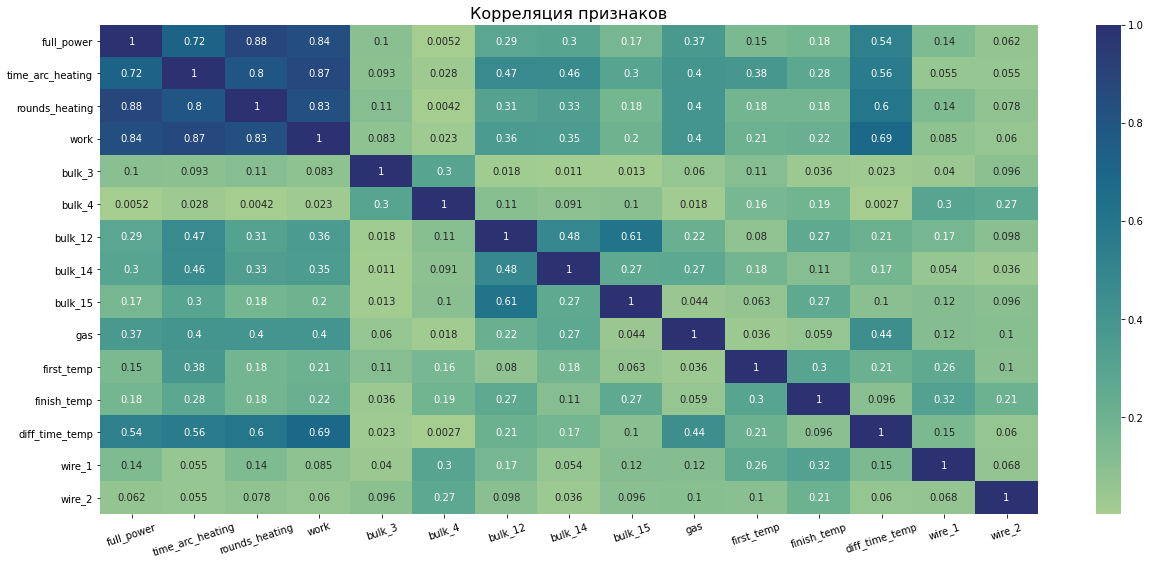

In [45]:
plt.figure(figsize=(21, 9))
fig = sns.heatmap(df.corr().abs(), cmap="crest", annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

В основном обьеме хитмеп довольно оптиместичный. Просматривается  высокая корреляция только между несколькими признаками: полной мощностью, работой, временем и количеством раундов нагрева. Выделим наиболее выжные из них после выбора конечной модели.

### Гистограммы  признаков.

Рассмотрим гистограммы по распределению признаков после обьединения.

Для этого пропишем функцию построения гистограмм.

In [46]:
def bar(data, row, row_rus, unit):
    data[row].plot(title = 'Распределение {}'.format(row_rus.upper()),
                          kind='hist', 
                          bins=200, 
                          grid=True, 
                          legend=True,
                          figsize=(20, 5),
                          alpha=0.5,
                         ).set(xlabel=unit, ylabel='количество партий') 
    
    plt.show()

Рассмотрим графики распределения группами признаков сходных по технологическому процессу.

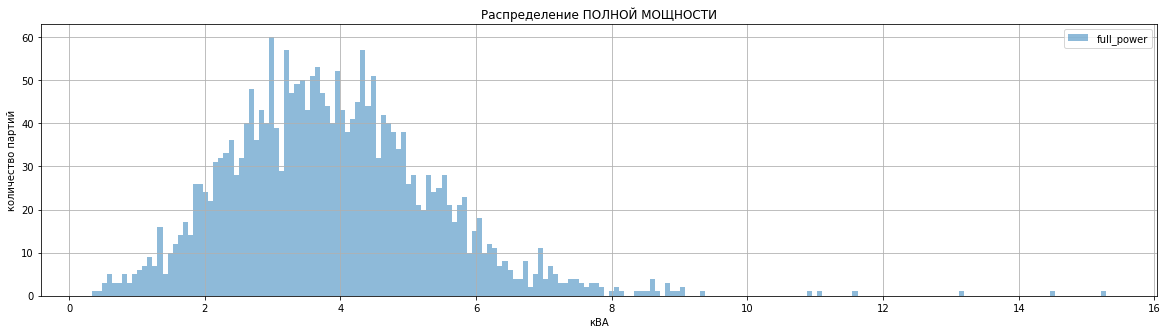

In [47]:
bar(df, 'full_power','полной мощности', 'кВА')

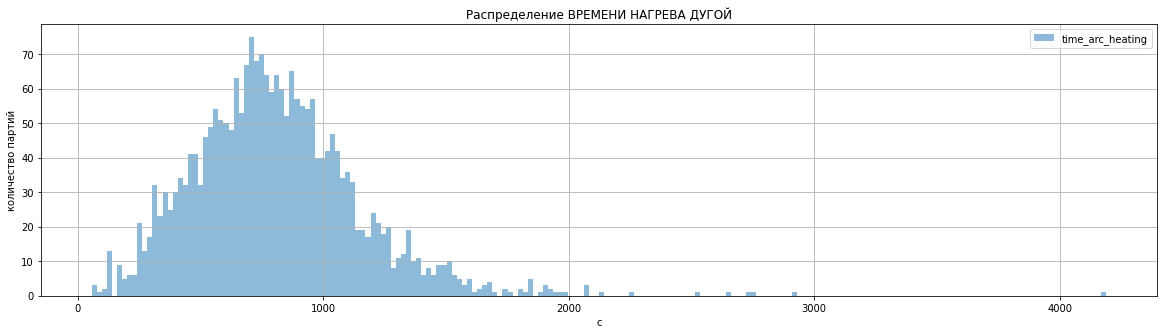

In [48]:
bar(df, 'time_arc_heating','времени нагрева дугой', 'с')

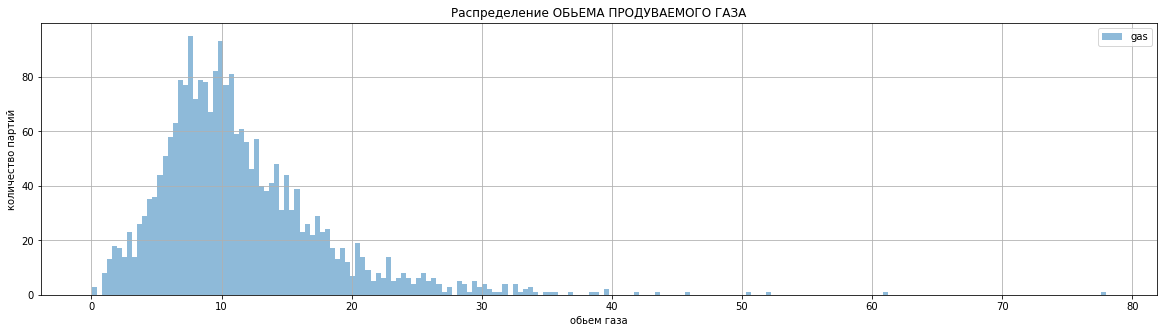

In [49]:
bar(df, 'gas','обьема продуваемого газа', 'обьем газа')

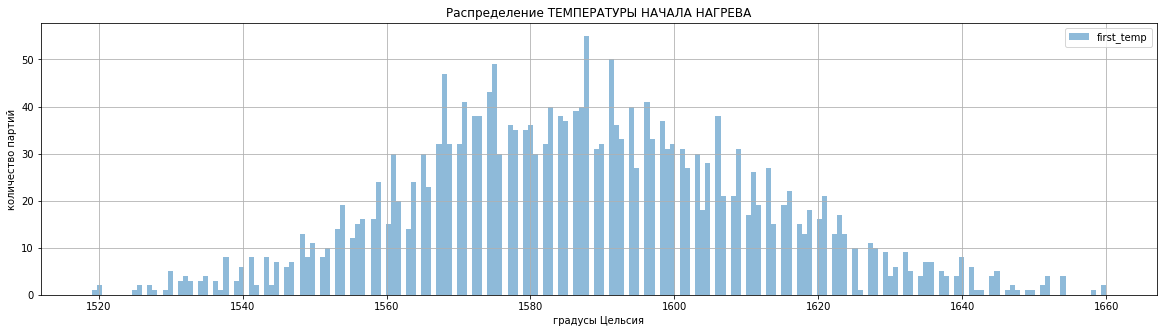

In [50]:
bar(df, 'first_temp','температуры начала нагрева', 'градусы Цельсия')

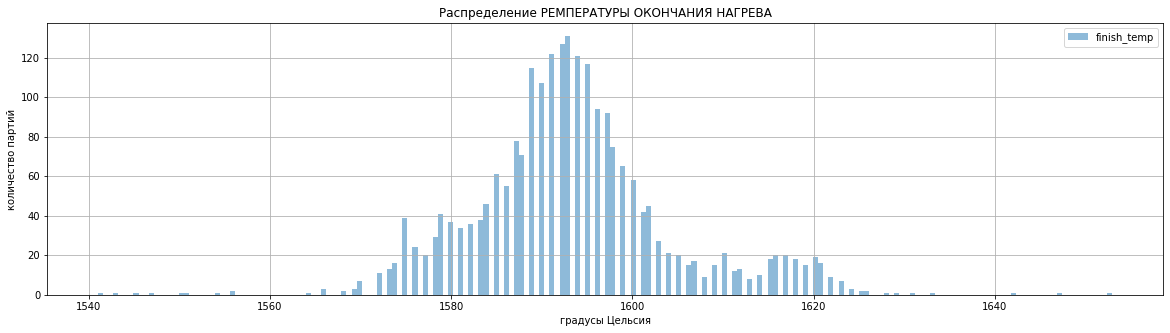

In [51]:
bar(df, 'finish_temp','ремпературы окончания нагрева', 'градусы Цельсия')

В целом распределение данных близко к нормальному. Есть пиковые показатели и крайне высокие показатели полной мощности/времени нагрева дугой/обьема газа. Избавиться от них с помощью квантилей распределения выглядит вполне логичным. Это возможно будет сделать после разделения данных на тренировочный и тестовый датасеты. 

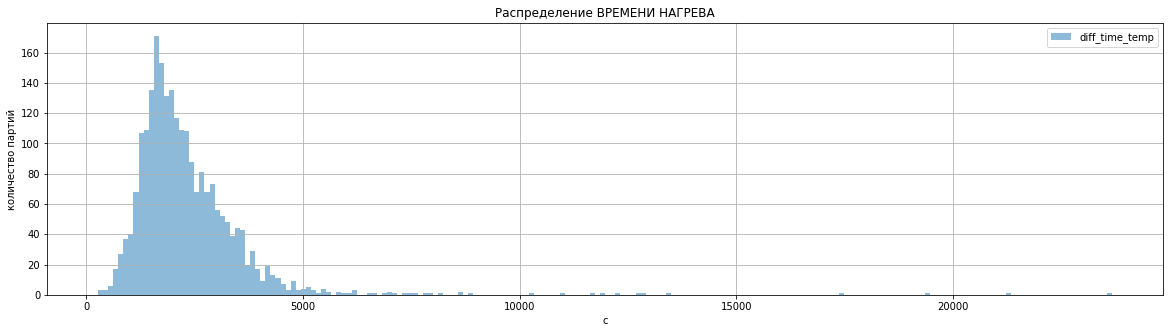

In [52]:
bar(df, 'diff_time_temp','времени нагрева', 'с')

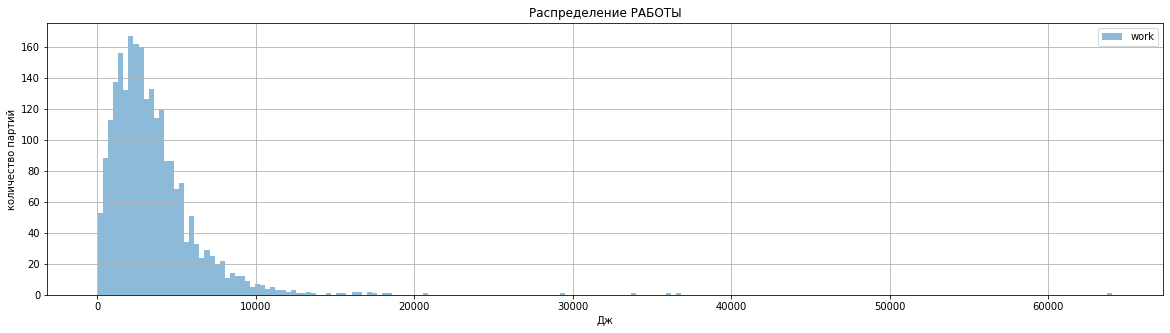

In [53]:
bar(df, 'work','работы', 'Дж')

Графики распределения работы и времени нагрева так же демонстрируют нормальное распределение данных, но уже со сдвигом пика влево. Так же присутствуют редкие, критически высокие показатели в данных.

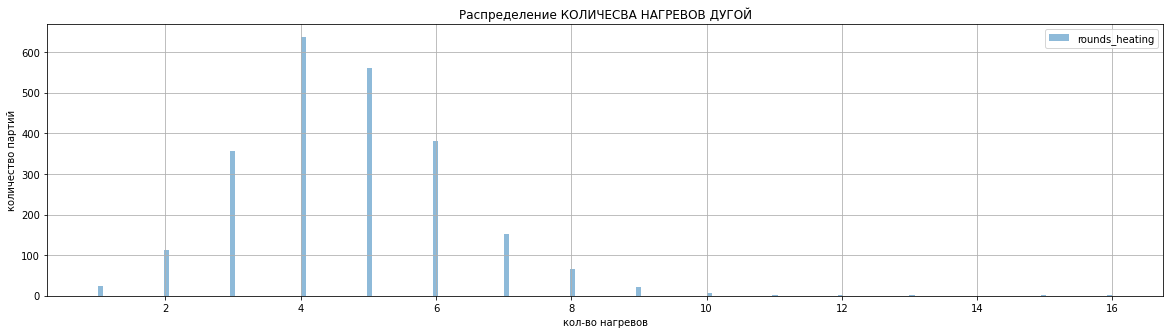

In [54]:
bar(df, 'rounds_heating','количесва нагревов дугой', 'кол-во нагревов')

Для данного признака гистограмма похожа больше на диаграмму, т.к. представлен количественный признак категорального характера.

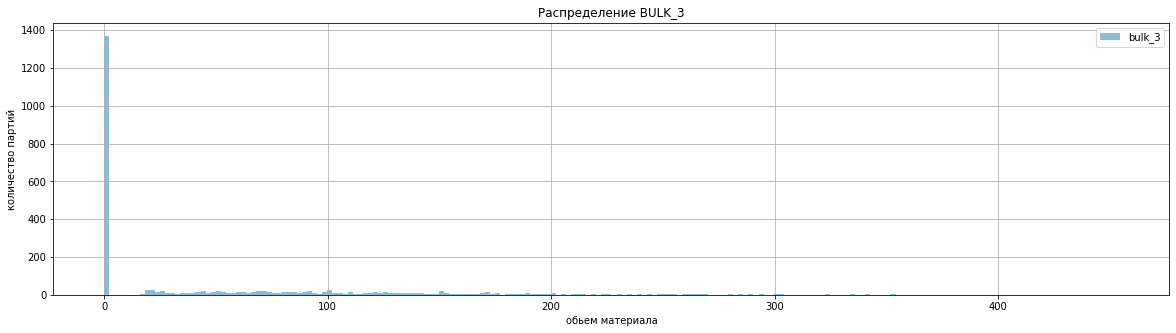

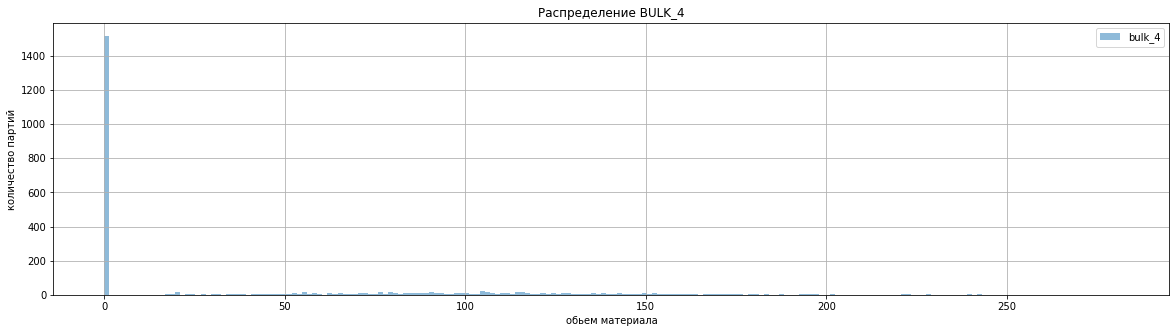

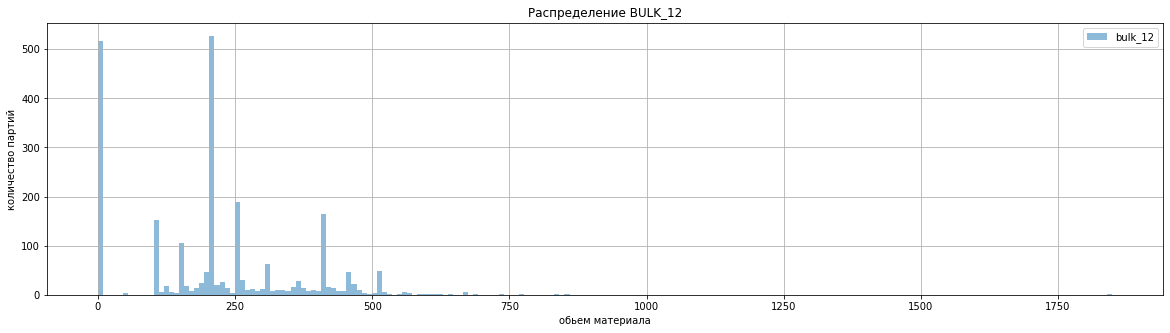

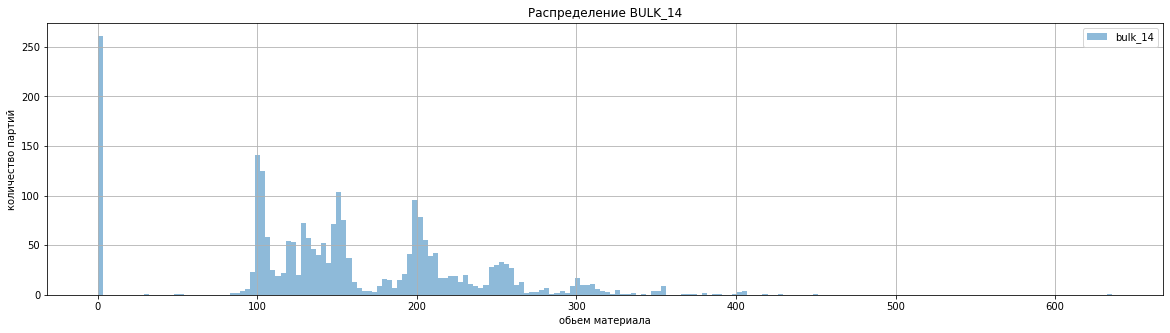

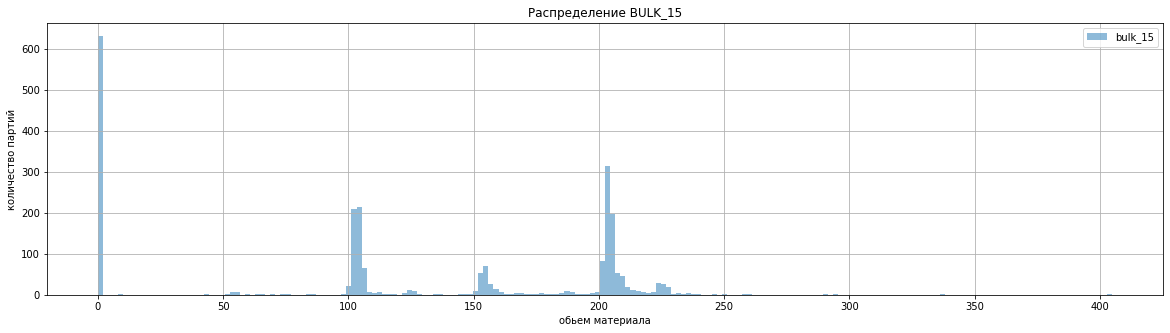

In [55]:
bulk_all = ['bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15']
for bulk in bulk_all:
    bar(df, bulk, bulk, 'обьем материала')

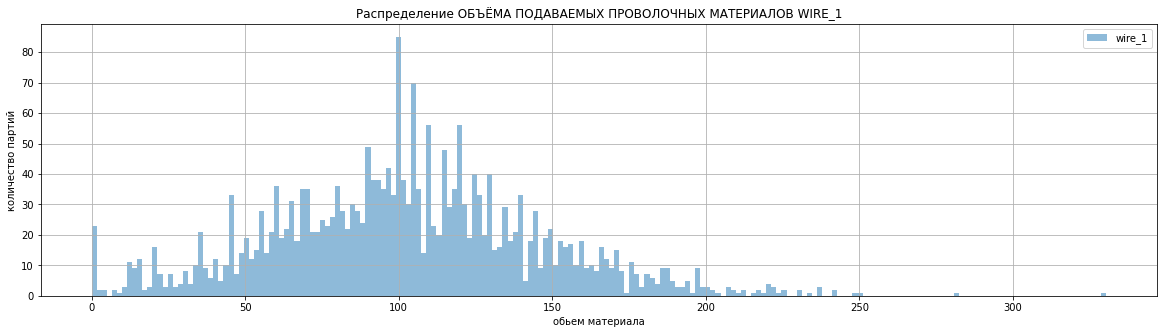

In [56]:
bar(df, 'wire_1','объёма подаваемых проволочных материалов wire_1', 'обьем материала')

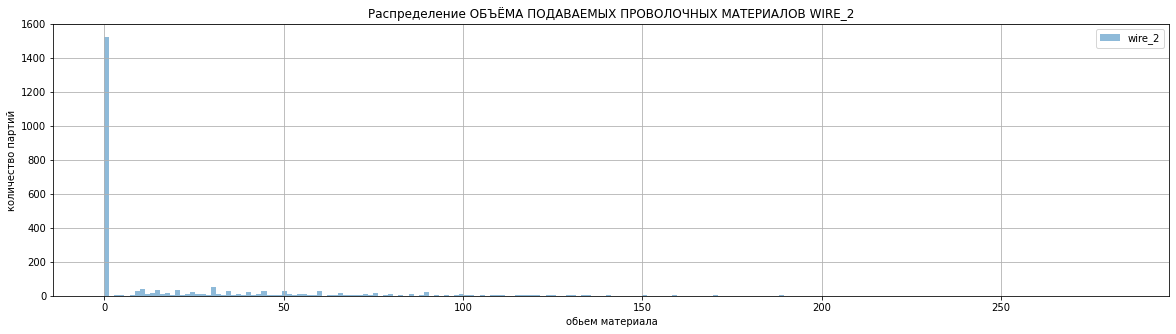

In [57]:
bar(df, 'wire_2','объёма подаваемых проволочных материалов wire_2', 'обьем материала')

В данных об объемах сыпучих и проволочных материалов явно заметны нулевые значения. Эти показатели не случайны и не являются выбросами, т.к. объясняются технологическим процессом: в каждой партии может использоваться индивидуальное кол-во добавляемых материалов в разных объемах. Яркие пиковые значения обьясняются применением мерной дозировки подачи того или иного материала в сплав. 

### Вывод

Проведено исследование объединенного датасета df.

По каждому признаку:
- выявлены интервалы фактических и нормальных значений,
- подсчитано процентное содержание аномальных и нулевых значений,
- построены гистограммы распределения признаков,
- рассчитаны корреляции с остальными признаками.

Приктически во всех признаках наблюдается небольшое количество аномальныч значений - до 7,7%.
В материальных признаках выявлены нулевые значения обусловленные производственным процессом. 
Матрица корреляции показала группу из 4-х признаков с высокими показателями: full_power, time_arc_heating, rounds_heating и	work. Все эти признаки были созданы в процессе предобработки данных. Для оценки значимости признаков в паре высокой корреляции необходимо будет воспользоваться оценкой значимости персонально для каждой модели прогнозирования.

## Подготовка данных

### Выделение целевого признака

In [73]:
# все признаки
features = df.drop(columns='finish_temp')

# целевой признак
target = df['finish_temp']

### Разделение на тренировочную и тестовую выборки

In [74]:
# Разделяем преобразованный датасет на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True
)
print('Объемы выборок:',
      'Тренировочная', features_train.shape,
      'Тестовая', features_test.shape)

Объемы выборок: Тренировочная (1746, 14) Тестовая (583, 14)


Удалим выбросы по основным значимым признакам тренировочной выборки.

In [75]:
# отфильтруем признаки по значениям квантилей.
features_train = features_train.query('full_power < 8 and time_arc_heating < 1660')
target_train = target_train[target_train.index.isin(features_train.index)]

print(target_train.shape,
      features_train.shape)

(1710,) (1710, 14)


### Вывод

В данных выделен целевой пизнак, они разделены на обучающую и тестовую выборки в соотношении 75/25. Удалены выбросы по столбцам полной мощности и времени нагрева. Данные подготовлены к построению моделей. 

## Обучение моделей машинного обучения

Перед нами стоит задача регресии, значит отберем следующие модели для обучения:
- LinearRegression,
- RandomForestRegressor,
- CatBoostRegressor.


**Выполним поиск лучшей модели для предсказаний**

В качестве **baseline** модели будем использовать DummyRegressor.

In [76]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_regr_pred = dummy_regr.predict(features_train)
dummy_regr_mae = mean_absolute_error(target_train, dummy_regr_pred)
print(f'RMSE на тестовой выборке: {dummy_regr_mae:.4f}')

RMSE на тестовой выборке: 7.9336


### Линейная регрессия

Перед построением линейной модели удалим из датасета признаки из сильно коррелирующих пар.
Пренебрежем work и rounds_heating, т.к. full_power и time_arc_heating основные признаки в данных.

In [77]:
features_train_lr = features_train.drop(columns=['work', 'rounds_heating'])

In [78]:
#кодирование признаков: все признаки масштабируются.
col_transformer_lr = make_column_transformer(
    (
        StandardScaler(),
        features_train_lr.select_dtypes(exclude='int').columns.to_list()
    ),
    remainder='passthrough'
)

In [79]:
model_lr = LinearRegression()

pipline_lr = make_pipeline(col_transformer_lr,  model_lr)

params = {}

grid_lr = GridSearchCV(pipline_lr, 
                       params, 
                       cv=5, 
                       scoring='neg_mean_absolute_error')

grid_lr.fit(features_train_lr, target_train)

grid_lr_best_score = abs(grid_lr.best_score_)

# лучшее значение RMSE на кросс-валидации
print(f'RMSE на тестовой выборке: {grid_lr_best_score:.4f}')

RMSE на тестовой выборке: 5.9473


### Cлучайный лес

In [80]:
#кодирование признаков: все признаки масштабируются.
col_transformer_forest = make_column_transformer(
    (
        StandardScaler(),
        features_train.select_dtypes(exclude='int').columns.to_list()
    ),
    remainder='passthrough'
)
model_forest = RandomForestRegressor()

pipline_forest = make_pipeline(col_transformer_forest,  model_forest)

params = {'randomforestregressor__n_estimators': [100], #исходный диапазон[90, 100, 120],
          'randomforestregressor__max_depth': [15], #исходный диапазон [10, 15, 20],
          'randomforestregressor__min_samples_split': [8], #исходный диапазон [6, 8, 10],
          'randomforestregressor__bootstrap': [True, False],
          'randomforestregressor__random_state': [RANDOM_STATE]
         }

grid_forest = GridSearchCV(pipline_forest, 
                       params, 
                       cv=5, 
                       scoring='neg_mean_absolute_error')

grid_forest.fit(features_train, target_train)

grid_forest_best_score = abs(grid_forest.best_score_)


best_params_forest = grid_forest.best_params_
grid_forest_best_score = abs(grid_forest.best_score_) 

print(f'Лучшее значение метрики качества (train): {grid_forest_best_score:.4f}')
print(f'Лучшие гиперпараметры: {best_params_forest}')

Лучшее значение метрики качества (train): 6.0111
Лучшие гиперпараметры: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 15, 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': None}


Лучшее значение метрики качества (train): 6.0111
Лучшие гиперпараметры: {'bootstrap': True, 'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 100, 'random_state': None}

### CatBoostRegressor 
без кодирования

In [81]:
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE) 

param_grid_cbr = {'learning_rate': [0.1], #исходный диапазон [0.1, 0.2],
                  'depth': [5], #исходный диапазон [3, 4, 5, 6],
                  'n_estimators': [300], #исходный диапазон [100, 200, 300],
                  'l2_leaf_reg': [7] #исходный диапазон [5, 7, 9]
                 }

# будем использовать RandomizedSearchCV
grid_cbr = RandomizedSearchCV(model_cbr,
                            param_distributions=param_grid_cbr,
                            scoring='neg_mean_absolute_error',
                            cv=3
                           )

grid_cbr.fit(features_train, target_train)

best_params_cbr = grid_cbr.best_params_
grid_cbr_best_score = abs(grid_cbr.best_score_)
print(f'Лучшее значение метрики качества (train): {grid_cbr_best_score:.2f}')
print(f'Лучшие гиперпараметры: {best_params_cbr}')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 10.8198094	total: 2.08ms	remaining: 623ms
1:	learn: 10.6411934	total: 4.07ms	remaining: 606ms
2:	learn: 10.4463241	total: 5.84ms	remaining: 578ms
3:	learn: 10.2923206	total: 7.66ms	remaining: 567ms
4:	learn: 10.1022413	total: 9.5ms	remaining: 561ms
5:	learn: 9.9282823	total: 11.3ms	remaining: 556ms
6:	learn: 9.7854666	total: 13.1ms	remaining: 548ms
7:	learn: 9.6515045	total: 15ms	remaining: 546ms
8:	learn: 9.5305654	total: 16.7ms	remaining: 539ms
9:	learn: 9.4101477	total: 18.5ms	remaining: 538ms
10:	learn: 9.3225035	total: 20.4ms	remaining: 535ms
11:	learn: 9.1954953	total: 22.2ms	remaining: 533ms
12:	learn: 9.1041545	total: 24.1ms	remaining: 532ms
13:	learn: 9.0313443	total: 25.9ms	remaining: 528ms
14:	learn: 8.9324510	total: 27.6ms	remaining: 524ms
15:	learn: 8.8730419	total: 29.4ms	remaining: 521ms
16:	learn: 8.7914743	total: 31ms	remaining: 516ms
17:	learn: 8.7073817	total: 32.8ms	remaining: 513ms
18:	learn: 8.6468349	total: 34.6ms	remaining: 511ms
19:	learn: 8.5666233	t

Лучшее значение метрики качества (train): 5.88
Лучшие гиперпараметры: {'n_estimators': 300, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'depth': 5}

Попробуем подобрать другие гиперпараметры модели.

In [82]:
param_grid_cbr2 = {'learning_rate': [0.1], #исходный диапазон [0.03, 0.1],
                  'iterations': [100], #исходный диапазон [50, 100, 150, 200],
                  'reg_lambda': [4],  #исходный диапазон [3, 4, 5, 6],
                   'verbose': [False] #исходный диапазон [False]
                 }

# будем использовать RandomizedSearchCV
grid_cbr2 = RandomizedSearchCV(model_cbr,
                            param_distributions=param_grid_cbr2,
                            scoring='neg_mean_absolute_error',
                            cv=3
                           )

grid_cbr2.fit(features_train, target_train)

best_params_cbr = grid_cbr2.best_params_
grid_cbr_best_score = abs(grid_cbr2.best_score_)
print(f'Лучшее значение метрики качества (train): {grid_cbr_best_score:.2f}')
print(f'Лучшие гиперпараметры: {best_params_cbr}')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшее значение метрики качества (train): 6.01
Лучшие гиперпараметры: {'verbose': False, 'reg_lambda': 4, 'learning_rate': 0.1, 'iterations': 100}


Первый набор гиперпараметров помог модели добиться лучших результатов. 

### Вывод


Были рассмотрены 3 модели, хорошо себя зарекомендовавшие в решении задач регрессии.
Все три модели показали уверенно хорошие результаты в сравнении с baseline моделью MAE(train)=7,9.

- LinearRegression MAE(train)=5.9473,
- RandomForestRegressor MAE(train)=6.0111,
- CatBoostRegressor MAE(train)=5.88.

Для достижения наилучших показателей моделями:
- проведена корректировка коллерирующих признаков для Линейной модели, 
- подобраны гиперпараметры для Случайного леса и CatBoost.

Лучшей оказалась модель CatBoost со значением метрики качества (train): 5.88 и гиперпараметрами: {'n_estimators': 300, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'depth': 5}

## Лучшая модель

In [89]:
model_last = CatBoostRegressor(
    depth=5,
    learning_rate=0.1,
    n_estimators=300,
    l2_leaf_reg=7,
    random_state=RANDOM_STATE,
   )

model_last.fit(features_train, target_train)
predictions = model_last.predict(features_test)
result = mean_absolute_error(target_test, predictions)
print(f'MAE (test): {result:.2f}')

# Вычисляем коэффициент детерминации R2
r2 = r2_score(target_test, predictions)

print("Коэффициент детерминации R2:", r2)

0:	learn: 10.7031047	total: 2.05ms	remaining: 612ms
1:	learn: 10.4924068	total: 4.3ms	remaining: 641ms
2:	learn: 10.3090730	total: 6.17ms	remaining: 610ms
3:	learn: 10.1557914	total: 8.2ms	remaining: 607ms
4:	learn: 9.9885249	total: 10.2ms	remaining: 600ms
5:	learn: 9.8357889	total: 12.1ms	remaining: 594ms
6:	learn: 9.6786406	total: 14ms	remaining: 588ms
7:	learn: 9.5548497	total: 16ms	remaining: 583ms
8:	learn: 9.4308095	total: 18ms	remaining: 582ms
9:	learn: 9.3334218	total: 20ms	remaining: 580ms
10:	learn: 9.2413640	total: 21.9ms	remaining: 576ms
11:	learn: 9.1437751	total: 24ms	remaining: 575ms
12:	learn: 9.0619169	total: 25.8ms	remaining: 569ms
13:	learn: 8.9722178	total: 27.8ms	remaining: 568ms
14:	learn: 8.8899915	total: 29.8ms	remaining: 566ms
15:	learn: 8.8414657	total: 31.7ms	remaining: 562ms
16:	learn: 8.7721977	total: 33.7ms	remaining: 561ms
17:	learn: 8.7162300	total: 35.6ms	remaining: 558ms
18:	learn: 8.6641788	total: 37.7ms	remaining: 558ms
19:	learn: 8.5975820	total: 39

MAE (test): 5.99 хуже, чем на тренировочных данных.
Коэффициент детерминации R2: 0.462 показывает, что модель лишь в 46,2% случаев показывает правильный результат на новых данных.

Сравним прогноз с  baseline моделью

In [84]:
#dummy_regr = DummyRegressor(strategy="mean")
#dummy_regr.fit(features_train, target_train)
dummy_regr_pred_test = dummy_regr.predict(features_test)
dummy_regr_mae = mean_absolute_error(target_test, dummy_regr_pred_test)
print(f'RMSE на тестовой выборке: {dummy_regr_mae:.4f}')

RMSE на тестовой выборке: 8.0001


Базовая модель так же показала более высокий показатель на тестовой выборке, чем на тренировочной. Это может быть вызвано оставшимися в данных выбросах и излишним количеством признаков для обучения модели.

Проверим важность признаков для конечной модели CatBoost с помощью feature_importances_

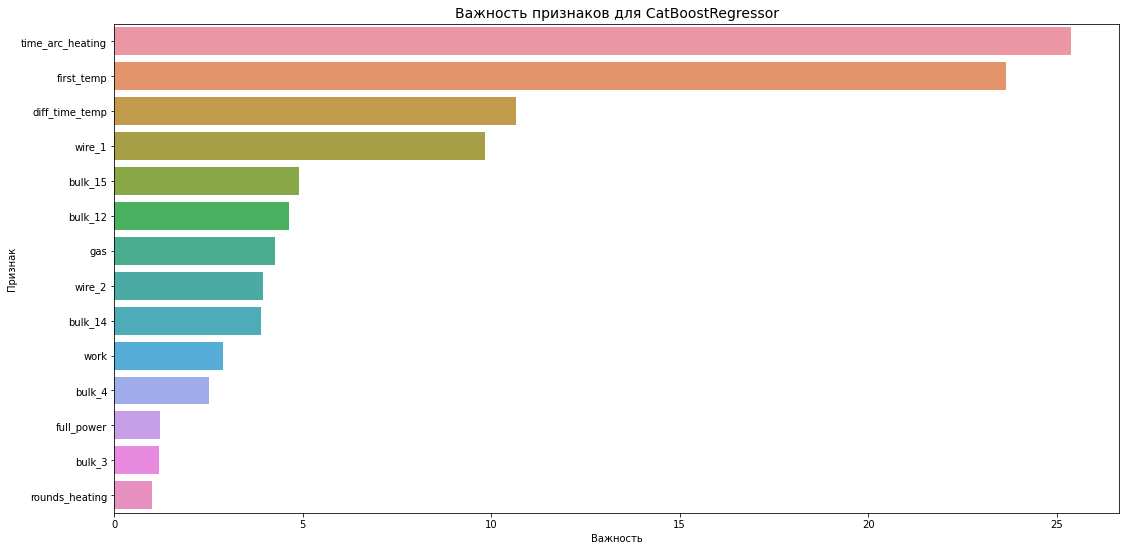

In [85]:
plot_data = {'features': features_test.columns,
             'feature_importances': model_last.feature_importances_
            }

plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

Возьмем признаки с наибольшей корреляцией из пункта 5.1: full_power, time_arc_heating, rounds_heating, work.
Удалим признаки с наименьшей значимостью для итоговой модели (full_power, bulk_3, bulk_4, rounds_heating) и признак work c  высокой корреляцией к основным признакам. Проследим, как это отразится на результате.

In [90]:
features_train_new = features_train.copy()
features_test_new = features_test.copy()

features_train_new = features_train_new.drop(columns=['full_power', 'bulk_3', 'bulk_4', 'work', 'rounds_heating'])
features_test_new = features_test_new.drop(columns=['full_power', 'bulk_3', 'bulk_4', 'work',  'rounds_heating'])

In [91]:
model_last.fit(features_train_new, target_train)
predictions = model_last.predict(features_test_new)

result = mean_absolute_error(target_test, predictions)
print(f'MAE (test): {result:.2f}')
r2 = r2_score(target_test, predictions)
print("Коэффициент детерминации R2:", r2)

0:	learn: 10.6824721	total: 1.68ms	remaining: 501ms
1:	learn: 10.4599055	total: 3.27ms	remaining: 488ms
2:	learn: 10.2393219	total: 4.82ms	remaining: 478ms
3:	learn: 10.1062196	total: 6.27ms	remaining: 464ms
4:	learn: 9.9540994	total: 7.63ms	remaining: 450ms
5:	learn: 9.8032277	total: 9.07ms	remaining: 445ms
6:	learn: 9.6597606	total: 10.6ms	remaining: 445ms
7:	learn: 9.5240140	total: 12.1ms	remaining: 441ms
8:	learn: 9.4319988	total: 13.5ms	remaining: 438ms
9:	learn: 9.3147582	total: 15ms	remaining: 434ms
10:	learn: 9.2369734	total: 16.3ms	remaining: 428ms
11:	learn: 9.1411593	total: 17.8ms	remaining: 426ms
12:	learn: 9.0676672	total: 19.2ms	remaining: 424ms
13:	learn: 8.9718151	total: 20.6ms	remaining: 421ms
14:	learn: 8.8584167	total: 22ms	remaining: 419ms
15:	learn: 8.7792201	total: 23.4ms	remaining: 415ms
16:	learn: 8.7336839	total: 24.9ms	remaining: 414ms
17:	learn: 8.6597108	total: 26.3ms	remaining: 411ms
18:	learn: 8.6057885	total: 27.7ms	remaining: 410ms
19:	learn: 8.5509213	t

MAE (test): 5.99
Коэффициент детерминации R2: 0.45952946274825757

Улучшились показатели качества модели. 
Необходимые показатели достигнуты!

## Общий вывод и рекомендации заказчику

**Цель проекта достигнута!**

Построена модель, которая предсказывает конечную температуру сплава. Достигнут показатель качества модели машинного обучения **MAE 5.99**.


При работе с проектом было выполнено:

- Исследована задача,


- изучены данные и проведена их предобработка
 
 *(приведены к стандартному виду названия столбцов, обработаны пропуски и выбросы),*


- выделенны(из исходных) данные для построения модели
  
  *(не попали в выборку признаки, по которым было совсем незначительное количество данных по партиям, и данные о температуре и времени замеров , т.к. они были преобразованы в новые признаки),* 


- при помощи математических методов созданы новые признаки
  
  *(полная мощность, работа, кол-во нагревов в рамках каждой партии, начальная и конечная температуры, общее время нагрева)*,


- проведена корреляционная оценка признаков
  
  *(выявлены высоко коррелирующие признаки:полная мощность, работа, время и количество раундов нагрева)*,


- выделен целевой признак и проведено разделение данных для обучения/тестирования модели
  
  *(целевой признак - конечная температура нагрева, данные разделены в соотношении 75/25)*,


- исследованы 3 модели с подбором гиперпараметров на кросс-валидации
  
  *(LinearRegression, RandomForestRegressor, CatBoostRegressor)*,


- выбрана наилучшая модель
  
  *(на обучающих данных лучшей себя показала CatBoostRegressor, показав метрику качества МАЕ(train): 5.88 с гиперпараметрами: {'n_estimators': 300, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'depth': 5} )*,


- проведено тестирование на данных неиспользуемых в обучении
  
  *(на тестовых данных CatBoost спрогнозировала результаты хуже, чем на обучающем датасете MAE (test): 5,99. Это свидетельствует о переобучении модели. Возможно, нужно больше внимания уделить выбросам в исходных данных или подобрать более подходящую комбинацию признаков. После удаление коллерирующих и наименее значимых признаков, удалось поднять качество модели до 5,99. Что не может ни радовать.)*.


Рекомендую предприятию применять прогнозные данные модели в целях уменьшения потребления электроэнергии. А так же использовать разработанную модель для имитации технологического процесса.
